In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:99%;}
div.CodeMirror {font-family:Consolas; font-size:20pt;}
div.output {font-size:18pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:19px;}
</style>
"""))

In [ ]:
# 얼굴인식(얼굴정보)-세로*가로*3 넘파이 -> 1*512(임베딩데이터로 변환) -> X, y를 머신러닝(SVM)

# 1. 데이터 셋 다운로드 및 압축해제
https://www.kaggle.com/datasets/dansbecker/5-celebrity-faces-dataset?resource=download

In [2]:
!unzip data/5celebrity.zip -d data/5celebrity/

Archive:  data/5celebrity.zip
   creating: data/5celebrity/train/
   creating: data/5celebrity/train/ben_afflek/
  inflating: data/5celebrity/train/ben_afflek/httpcsvkmeuaeccjpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg  
  inflating: data/5celebrity/train/ben_afflek/httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg  


# 2. 얼굴 Detect

In [ ]:
# ! pip install mtcnn

In [4]:
from mtcnn import MTCNN
import PIL
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 2.1 MTCNN을 이용해서 얼굴 형태 탐지

In [5]:
detector = MTCNN()
image = cv2.imread('data/5celebrity/train/ben_afflek/httpcsvkmeuaeccjpg.jpg',
                  cv2.IMREAD_ANYCOLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = detector.detect_faces(image)
result

[{'box': [14, 30, 76, 92],
  'confidence': 0.9998857975006104,
  'keypoints': {'nose': [36, 91],
   'mouth_right': [64, 98],
   'right_eye': [51, 63],
   'left_eye': [27, 75],
   'mouth_left': [44, 109]}}]

## 2-2 탐지한 얼굴 그려보기

In [17]:
box = result[0]['box'] # 왼쪽위부분의 x, y, width, height
x, y, w, h = box
keypoints = result[0]['keypoints'] # nose, mouth_right,right_eye, left_eye,mouth_left
cv2.rectangle(image, 
             (x, y), # 사각형 왼쪽윗부분 좌표
             (x+w, y+h), # 사각형 오른쪽 밑부분 좌표
             (0, 155, 255),
              2)
cv2.circle(image, keypoints['nose'], # 원의 중심점
          2, # 반지름
          (255,0,0), #원 색상
          2)
cv2.circle(image, keypoints['mouth_right'], 2,  (255,0,0), 2)
cv2.circle(image, keypoints['right_eye'], 2,  (255,0,0), 2)
cv2.circle(image, keypoints['left_eye'], 2,  (255,0,0), 2)
cv2.circle(image, keypoints['mouth_left'], 2,  (255,0,0), 2)
cv2.imwrite('data/ben.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

face = image[y:y+h, x:x+w]
cv2.imwrite('data/benface.jpg', cv2.cvtColor(face, cv2.COLOR_RGB2BGR))

True

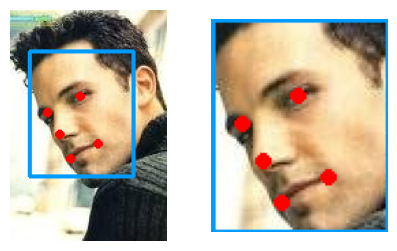

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(5,3))
axes[0].imshow(image)
axes[0].axis('off')
axes[1].imshow(face)
axes[1].axis('off')
plt.show()

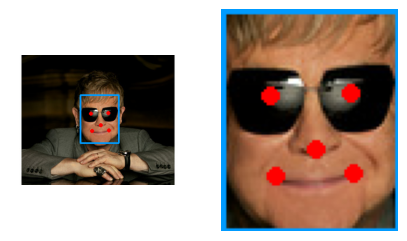

In [21]:
image = cv2.imread('data/5celebrity/train/elton_john/12.jpg',
                  cv2.IMREAD_ANYCOLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = detector.detect_faces(image)
box = result[0]['box'] # 왼쪽위부분의 x, y, width, height
x, y, w, h = box
keypoints = result[0]['keypoints'] # nose, mouth_right,right_eye, left_eye,mouth_left
cv2.rectangle(image, (x, y), (x+w, y+h), (0, 155, 255),2)
cv2.circle(image, keypoints['nose'], 2, (255,0,0), 2)
cv2.circle(image, keypoints['mouth_right'], 2,  (255,0,0), 2)
cv2.circle(image, keypoints['right_eye'], 2,  (255,0,0), 2)
cv2.circle(image, keypoints['left_eye'], 2,  (255,0,0), 2)
cv2.circle(image, keypoints['mouth_left'], 2,  (255,0,0), 2)
face = image[y:y+h, x:x+w]
fig, axes = plt.subplots(1, 2, figsize=(5,3))
axes[0].imshow(image)
axes[0].axis('off')
axes[1].imshow(face)
axes[1].axis('off')
plt.show()

## 2.3 입력형식에 맞게 차원 변환

In [22]:
face.shape

(83, 66, 3)

In [26]:
face_data = np.expand_dims(face, axis=0)
# face_data = face.reshape(-1, face.shape[0], face.shape[1], face.shape[2]) 비추
face_data = face[np.newaxis, :]
face_data.shape

(1, 83, 66, 3)

# 3. Facenet 활용하여 임베딩 데이터로 변환(face_data를)
- face_data : 1x83x66x3
- 임베딩 데이터 : 1x512

In [ ]:
# ! pip install keras-facenet

In [27]:
from keras_facenet import FaceNet
model = FaceNet()

## 3-1 이미지 데이터를 FaceNet 임베딩 데이터로 변환

In [28]:
# face_data 얼굴 이미지이거나 얼굴 특징 데이터가 있는 이미지를 유사성을 측정할 수 있는 1x512 배열
face_embedding = model.embeddings(face_data)
face_embedding.shape

1/1 [==============================] - 11s 11s/step


(1, 512)

In [30]:
face_embedding[0, :10]

array([-0.00535406,  0.03481748,  0.06170098,  0.12021632,  0.00196333,
        0.04806108, -0.07896575, -0.04746441, -0.0599184 , -0.02178188],
      dtype=float32)

# 4. 분류모델을 만들기 위해서 데이터셋 생성
- X_train(nx512), y_train(n) * n은 train 폴더안의 사진 갯수
- X_test(mx512) y_test(m)    * m은 test 폴더안의 사진 갯수
## 4.1 y_train(사람이름)과 X_train에 사용될 이미지 경로(x_train_path)
- y_test(사람이름)과 X_test에 사용될 이미지 경로(x_test_path)

In [31]:
import os
train_path = 'data/5celebrity/train'
test_path  = 'data/5celebrity/val'

In [34]:
for x in os.walk(train_path):
    print(x)
    print('-----------------------------')

('data/5celebrity/train', ['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling'], [])
-----------------------------
('data/5celebrity/train\\ben_afflek', [], ['httpcsvkmeuaeccjpg.jpg', 'httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg', 'httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg', 'httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg', 'httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg', 'httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg', 'httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg', 'httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg', 'httptrwebimgacstanetcxbdddmediasnmediajpg.jpg', 'httpwwwaceshowbizcomimagesphotobenaffleckjpg.jpg', 'httpwwwallposterscomimagesPostersPFjpg.jpg', 'httpwwwfilmscoopitcgibinattoriBENAFFLECKBENAFFLECKjpg.jpg', 'httpwwwhillsindcomstorebenjpg.jpg', 'httpwwwrumenewscomwpcontentuploadsbenafflekxpng.j

In [67]:
def get_path(path):
    x_path = []
    y = []
    for x in os.walk(path):
        if len(x[2])==0:
            # print(x, '에는 파일이 없네요')
            continue
        name = os.path.basename(x[0])
        print(name, '사진', len(x[2]), '장 parsing 중')
        for file_name in x[2]:
            # image_full_path = x[0].replace('\\','/') + '/' + file_name
            image_full_path = path + '/' + name + '/' + file_name
            x_path.append(image_full_path)
            y.append(name)
#     print(len(y))
#     print(len(x_path))
#     for name, path in zip(y, x_path):
#         print(name, path)
    return x_path, y

In [68]:
# get_path(train_path)
x_train_path, y_train = get_path(train_path)
x_test_path, y_test = get_path(test_path)

ben_afflek 사진 14 장 parsing 중
elton_john 사진 16 장 parsing 중
jerry_seinfeld 사진 21 장 parsing 중
madonna 사진 19 장 parsing 중
mindy_kaling 사진 22 장 parsing 중
ben_afflek 사진 5 장 parsing 중
elton_john 사진 5 장 parsing 중
jerry_seinfeld 사진 5 장 parsing 중
madonna 사진 5 장 parsing 중
mindy_kaling 사진 5 장 parsing 중
